In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [10]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [11]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

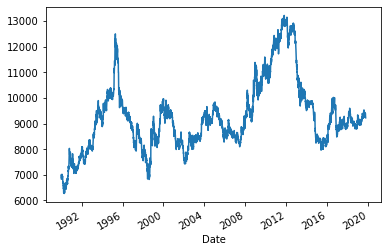

In [12]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [13]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise_settle, ts_trend_settle = sm.tsa.filters.hpfilter(yen_futures['Settle'])
ts_noise_settle.head()

Date
1990-01-02   -61.503967
1990-01-03   -21.799756
1990-01-04    98.942896
1990-01-05    40.776052
1990-01-08    49.689938
Name: Settle_cycle, dtype: float64

In [14]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_settle = yen_futures['Settle']
yen_settle.head()
joined_yen = pd.concat([yen_settle, ts_noise_settle, ts_trend_settle], axis='columns', join='inner')
columns = ['Settle', 'noise', 'trend']
joined_yen.columns = columns
joined_yen.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


TypeError: unsupported operand type(s) for +: 'AxesSubplot' and 'AxesSubplot'

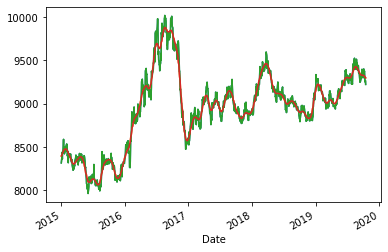

In [15]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_futures_2015 = joined_yen.loc["2015-01-01":, :]
yen_futures_2015.head()
yen_futures_2015_sd = yen_futures_2015.Settle.plot()
yen_futures_2015_trend = yen_futures_2015.trend.plot()
plot = yen_futures_2015.Settle.plot() + yen_futures_2015.trend.plot()
plot.plot()

<AxesSubplot:xlabel='Date'>

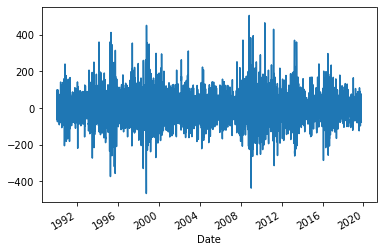

In [16]:
# Plot the Settle Noise
ts_noise_settle.plot()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [17]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [18]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model_ARMA = ARMA(returns.values, order=(1,1))

# Fit the model and assign it to a variable called results
results_ARMA = model_ARMA.fit()

C:\Users\jwber\anaconda3\envs\machinelearning\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [19]:
# Output model summary results:
results_ARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(1, 1)   Log Likelihood               -7893.399
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 03 Dec 2020   AIC                          15794.798
Time:                        19:08:24   BIC                          15822.496
Sample:                             0   HQIC                         15804.309
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.830      0.406      -0.009       0.021
ar.L1.y        0.6985      0.188      3.712      0.000       0.330       1.067
ma.L1.y       -0.7112      0.185     -3.850      0.000      -1.073      -0.349
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4317           +0.0000j            1.4317            0.0000
MA.1            1.4061           +0.0000j            1.4061            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Yen Futures Return 5 day Forecast ARMA'}>

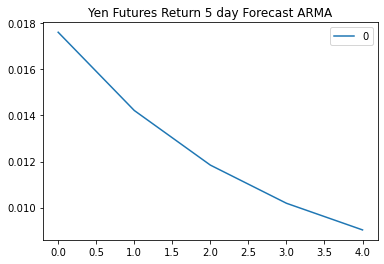

In [20]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results_ARMA.forecast(steps=5)[0]).plot(title="Yen Futures Return 5 day Forecast ARMA")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [21]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model_ARIMA = ARIMA(returns, order=(5, 1, 1))

# Fit the model
results_ARIMA = model_ARIMA.fit()

C:\Users\jwber\anaconda3\envs\machinelearning\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\jwber\anaconda3\envs\machinelearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

In [22]:
# Output model summary results:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7513
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7895.586
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 03 Dec 2020   AIC                          15807.173
Time:                        19:08:52   BIC                          15862.568
Sample:                             1   HQIC                         15826.194
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.199e-06   3.53e-06     -0.905      0.365   -1.01e-05    3.73e-06
ar.L1.D.Settle    -0.0118      0.012     -1.022      0.307      -0.034       0.011
ar.L2.D.Settle    -0.0003      0.012     -0.028      0.978      -0.023       0.022
ar.L3.D.Settle    -0.0133      0.012     -1.149      0.251      -0.036       0.009
ar.L4.D.Settle    -0.0194      0.012     -1.679      0.093      -0.042       0.003
ar.L5.D.Settle    -0.0022      0.012     -0.188      0.851      -0.025       0.020
ma.L1.D.Settle    -1.0000      0.000  -2529.227      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7454           -1.7637j            2.4813           -0.1258
AR.2            1.7454           +1.7637j            2.4813            0.1258
AR.3           -2.0687           -2.1817j            3.0066           -0.3708
AR.4           -2.0687           +2.1817j            3.0066            0.3708
AR.5           -8.2619           -0.0000j            8.2619           -0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Yen Futures Return 5 day Forecast ARIMA'}>

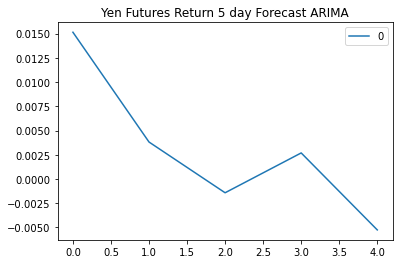

In [23]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results_ARIMA.forecast(steps=5)[0]).plot(title="Yen Futures Return 5 day Forecast ARIMA")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [24]:
from arch import arch_model

ModuleNotFoundError: No module named 'arch'

In [ ]:
# Estimate a GARCH model:
model_GARCH = arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)

# Fit the model
results_GARCH = model_GARCH.fit(disp='off')

In [ ]:
# Summarize the model results
results_GARCH.summary()

In [ ]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results_GARCH.forecast(start= last_day, horizon=forecast_horizon)
forecasts

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast
final.plot(title="Yen Futures Volatility 5 day Forecast GARCH")

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

A: I would not by the Yen right now as the porjected 5 returns are decreasing and volatility is increasing.  i may add a short position. At this point I would be willing to allocate some funds to using the ouput of these models but would want to fine tune it with more data